# Gesture Recognition
In this group project, we are going to build a 3D Conv model / CNN+RNN model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

### Important Notes For the Evaluator

##### There were some modifications needed in the starter code for convenience of experimentations and also performance considerations. 
##### Wherever changes were made, I have provided appropriate comments
##### Install the following versions in case needed to overcome errors, because some of the starter code needed specific versions of keras and tf

In [13]:
#!pip install scipy==1.2.1
#!pip install tensorflow==1.13.1
#!pip install keras==2.2.4

### Import Libraries

In [14]:
#*******************

import numpy as np
import os
from scipy.misc import imread, imresize
from skimage.transform import resize
from skimage import io
import datetime
import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [15]:
#*****************************

np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

### Basic Train and Test data exploration

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [16]:
#**************************


# Set the file path accordingly

#train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
#val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())

train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())

val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())

# We will experiment the batch size shortly
batch_size = 60 #experiment with the batch size

print(len(train_doc))

print(len(val_doc))

663
100


In [17]:
print(train_doc)

['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1\n'
 'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n'
 'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0\n'
 'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n'
 'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0\n'
 'WIN_20180926_17_30_47_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n'
 'WIN_20180926_17_29_23_Pro_Stop_new;Stop_new;2\n'
 'WIN_20180926_17_12_26_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n'
 'WIN_20180926_17_29_01_Pro_Stop_new;Stop_new;2\n'
 'WIN_20180907_16_32_11_Pro_Stop Gesture_new;Stop Gesture_new;2\n'
 'WIN_20180926_17_06_01_Pro_Stop_new;Stop_new;2\n'
 'WIN_20180907_16_52_18_Pro_Stop Gesture_new;Stop Gesture_new;2\n'
 'WIN_20180907_16_39_19_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0\n'
 'WIN_20180925_17_19_16_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n'
 'WIN_20180907_16_19_10_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0\n'
 'WIN_20180926_16_56_46_Pro

In [18]:
#************************

curr_dt_time = datetime.datetime.now()

# Set the file path accordingly

#train_path = '/notebooks/storage/Final_data/Collated_training/train'
#val_path = '/notebooks/storage/Final_data/Collated_training/val'

train_path = './Project_data/train'
val_path = './Project_data/val'

num_train_sequences = len(train_doc)
print('# Total training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# Total validation sequences =', num_val_sequences)


### We will set num_epochs later as it needs experimentation
#num_epochs =  # choose the number of epochs
#print ('# epochs =', num_epochs)

# Total training sequences = 663
# Total validation sequences = 100


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [19]:
#********************************************

def generator(source_path, folder_list, batch_size):
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]  #create a list of image numbers you want to use for a particular video
    x=len(img_idx)
    y=120
    z=120

    while True:
        
        t = np.random.permutation(folder_list)
        tot_size = len(t)
        num_batches = int(tot_size / batch_size) # calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
             
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size

                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                                      
              #      
               #     #crop the images and resize them. Note that the images are of 2 different shape 
                #    #and the conv3D will throw error if the inputs in a batch have different shapes
                 #   
                    image = resize(image, (y, z))
                    
                    batch_data[folder,idx,:,:] = image.astype('float32')
                    batch_data[folder,idx,:,:,0] = (batch_data[folder,idx,:,:,0].astype('float32')) / 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (batch_data[folder,idx,:,:,1].astype('float32')) / 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (batch_data[folder,idx,:,:,2].astype('float32')) / 255 #normalise and feed in the image

                    #
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                

            
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
      
        
        # write the code for the remaining data points which are left after full batches
        
        folders_done = num_batches * batch_size
        remaining_size = tot_size - folders_done

         
        batch_data = np.zeros((remaining_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((remaining_size,5)) # batch_labels is the one hot representation of the output
        
        if remaining_size > 0:
            for folder in range(remaining_size): # iterate over the batch_size

                imgs = os.listdir(source_path+'/'+ t[folder + folders_done].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + folders_done].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image, (y, z))
                                     
              #      
               #     #crop the images and resize them. Note that the images are of 2 different shape 
                #    #and the conv3D will throw error if the inputs in a batch have different shapes
                 #   
                    
                    batch_data[folder,idx,:,:] = image.astype('float32')
                    batch_data[folder,idx,:,:,0] = (batch_data[folder,idx,:,:,0].astype('float32')) / 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (batch_data[folder,idx,:,:,1].astype('float32')) / 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (batch_data[folder,idx,:,:,2].astype('float32')) / 255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + folders_done].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
 

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

##### Some helper functions

In [20]:
#*************************************

def print_param_details():
    
    print("Number of training Sequences :", num_train)
    print("Number of validation sequences :", num_val)
    print("Batch Size :", batch_size)
    print("Number of Epochs :", num_epochs)
    print("\n")

In [21]:
#***************************

import gc

def clear_model_mem(model):
    del model
    K.clear_session()
    gc.collect()


# Model Definitions
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
#****************

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import optimizers

#write your models here

# 1. Conv3D Models

# 2. CNN+RNN Models

############################ 1. CONV3D Models #############################

# conv3d_model_1
# Model with one Conv3d layer
#  Conv3D (32)  --> MaxPooling3D --> Dropout --> Flatten --> Dense --> Dropout --> Softmax

def create_conv3d_model_1():
 
    model = Sequential()

    # first conv layer
    seq_len = 15
    img_rows = 120
    img_cols = 120
    num_classes = 5

    input_shape = (seq_len, img_rows, img_cols, 3)

    model.add(Conv3D(32, kernel_size=(3, 3, 3),
                 activation='relu',
                 input_shape=input_shape)) # input shape = (img_rows, img_cols, 3)

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    # flatten and put a fully connected layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu')) # fully connected
    model.add(Dropout(0.5))

    # softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    return model




# conv3d_model_2
# conv3d_model_1 + extra Conv3d layer with 64 feature maps (filters)
#  Conv3D (32)  --> Conv3D (64) --> MaxPooling3D --> Dropout --> Flatten --> Dense --> Dropout --> Softmax

def create_conv3d_model_2():
    model = Sequential()

    # first conv layer
    seq_len = 15
    img_rows = 120
    img_cols = 120
    num_classes = 5

    input_shape = (seq_len, img_rows, img_cols, 3)

    model.add(Conv3D(32, kernel_size=(3, 3, 3),
                 activation='relu',
                 input_shape=input_shape)) # input shape = (img_rows, img_cols, 3)

    # second conv layer
    model.add(Conv3D(64, kernel_size=(3, 3, 3), 
                 activation='relu'))

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    # flatten and put a fully connected layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu')) # fully connected
    model.add(Dropout(0.5))

    # softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    return model




# conv3d_model_3
# conv3d_model_1 + extra Conv3d layer, but with 32 feature maps (filters) instead of 64.
# Conv3D (32)  --> Conv3D (32) --> MaxPooling3D --> Dropout --> Flatten --> Dense --> Dropout --> Softmax

def create_conv3d_model_3():

    model = Sequential()

    # first conv layer
    seq_len = 15
    img_rows = 120
    img_cols = 120
    num_classes = 5

    input_shape = (seq_len, img_rows, img_cols, 3)

    model.add(Conv3D(32, kernel_size=(3, 3, 3),
                 activation='relu',
                 input_shape=input_shape)) # input shape = (img_rows, img_cols, 3)

    # second conv layer with 32 feature maps
    model.add(Conv3D(32, kernel_size=(3, 3, 3), 
                 activation='relu'))

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    # flatten and put a fully connected layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu')) # fully connected
    model.add(Dropout(0.5))

    # softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    return model



# conv3d_model_4
# conv3d_model_3 + additional MaxPooling and dropout between the two Conv3D layers
#  Conv3D (32)  --> MaxPooling3D --> Dropout --> Conv3D (32) --> MaxPooling3D --> 
#            ----> Dropout --> Flatten --> Dense --> Dropout --> Softmax

def create_conv3d_model_4():

    model = Sequential()

    # first conv layer
    seq_len = 15
    img_rows = 120
    img_cols = 120
    num_classes = 5

    input_shape = (seq_len, img_rows, img_cols, 3)

    model.add(Conv3D(32, kernel_size=(3, 3, 3),
                 activation='relu',
                 input_shape=input_shape)) # input shape = (img_rows, img_cols, 3)
    
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))
    
    # second conv layer with 32 feature maps
    model.add(Conv3D(32, kernel_size=(3, 3, 3), 
                 activation='relu'))

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    # flatten and put a fully connected layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu')) # fully connected
    model.add(Dropout(0.5))

    # softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    return model




# conv3d_model_5
# conv3d_model_4 + BatchNormalization 
#  Conv3D (32)  --> BatchNormalization --> MaxPooling3D --> Dropout --> Conv3D (32) --> BatchNormalization --> MaxPooling3D --> 
#            ----> Dropout --> Flatten --> Dense --> Dropout --> Softmax


def create_conv3d_model_5():

    model = Sequential()

    # first conv layer
    seq_len = 15
    img_rows = 120
    img_cols = 120
    num_classes = 5

    input_shape = (seq_len, img_rows, img_cols, 3)

    model.add(Conv3D(32, kernel_size=(3, 3, 3),
                 activation='relu',
                 input_shape=input_shape)) # input shape = (img_rows, img_cols, 3)
    model.add(BatchNormalization())               #<<<<<<<<<<<<<<
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))
    
    # second conv layer with 32 feature maps
    model.add(Conv3D(32, kernel_size=(3, 3, 3), 
                 activation='relu'))
    model.add(BatchNormalization())   #<<<<<<<<<<<<<<<
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    # flatten and put a fully connected layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu')) # fully connected
    #model.add(Dropout(0.25))  #<<<<<<<<<
    model.add(Dropout(0.5))  
    # softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    return model





############################ 2. CNN + RNN Models #############################

# cnn_lstm_model_1
# Conv2D --> MaxPooling2D --> Flatten --> LSTM --> Dense --> Dropout --> Softmax

def create_cnn_lstm_model_1():
    model = Sequential()

    # first conv layer
    seq_len = 15
    img_rows = 120
    img_cols = 120
    num_classes = 5

    input_shape = (seq_len, img_rows, img_cols, 3)

    model.add( 
             TimeDistributed( 
                 Conv2D(32, kernel_size=(3, 3), activation='relu'),
                 input_shape=input_shape
             )
    )# input shape = (img_rows, img_cols, 3)

  
    model.add(
             TimeDistributed( 
                 MaxPooling2D(pool_size=(2, 2))
             )
    )
    
    # flatten and put a fully connected layer
    model.add(
             TimeDistributed(
                 Flatten()
             )
    )
    
    model.add(
             LSTM(128, activation='relu', return_sequences=False)
    )
    
    model.add(Dense(128, activation='relu')) # fully connected
    model.add(Dropout(0.5))

    # softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    return model




# cnn_gru_model_1 
# Conv2D --> MaxPooling2D --> Dropout --> Flatten --> GRU --> Dense --> Dropout --> Softmax

def create_cnn_gru_model_1():
    model = Sequential()

    # first conv layer
    seq_len = 15
    img_rows = 120
    img_cols = 120
    num_classes = 5

    input_shape = (seq_len, img_rows, img_cols, 3)

    model.add( 
             TimeDistributed( 
                 Conv2D(32, kernel_size=(3, 3), activation='relu'),
                 input_shape=input_shape
             )
    )# input shape = (img_rows, img_cols, 3)

    
    model.add(
             TimeDistributed( 
                 MaxPooling2D(pool_size=(2, 2))
             )
    )
    
    model.add(Dropout(0.25))

    # flatten and put a fully connected layer
    model.add(
             TimeDistributed(
                 Flatten()
             )
    )
    
    model.add(
             GRU(128, activation='relu', return_sequences=False)
    )
    
    model.add(Dense(128, activation='relu')) # fully connected
    model.add(Dropout(0.5))

    # softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    return model




# cnn_gru_model_2
# cnn_gru_model_1 + BatchNormalization
# Conv2D --> BatchNormalization --> MaxPooling2D --> BatchNormalization --> Dropout --> Flatten --> GRU -->
#  --> Dense --> Dropout --> Softmax

def create_cnn_gru_model_2():
    model = Sequential()

    # first conv layer
    seq_len = 15
    img_rows = 120
    img_cols = 120
    num_classes = 5

    input_shape = (seq_len, img_rows, img_cols, 3)

    model.add( 
             TimeDistributed( 
                 Conv2D(32, kernel_size=(3, 3), activation='relu'),
                 input_shape=input_shape
             )
    )# input shape = (img_rows, img_cols, 3)

    model.add(TimeDistributed(BatchNormalization()))               #<<<<<<<<<<<<<< 

    model.add(
             TimeDistributed( 
                 MaxPooling2D(pool_size=(2, 2))
             )
    )
              
    model.add(TimeDistributed(BatchNormalization()))               #<<<<<<<<<<<<<< 
    
    # Increased dropout ratio compared to GRU model-1 
    model.add(Dropout(0.5))  

    # flatten and put a fully connected layer
    model.add(
             TimeDistributed(
                 Flatten()
             )
    )
    
    model.add(
             GRU(128, activation='relu', return_sequences=False)
    )
    
    model.add(Dense(128, activation='relu')) # fully connected
    
    # Increased dropout ratio compared to GRU model-1 
    model.add(Dropout(0.5))

    # softmax layer
    model.add(Dense(num_classes, activation='softmax'))

    return model


# 1. CONV3D Models Experiments

## 1.1 Try a simple model first - Conv3d with a single conv layer  
##  conv3d_model_1 

#### Architecture = Conv3D (32)  --> MaxPooling3D --> Dropout --> Flatten --> Dense --> Dropout --> Softmax

Let us start with 

Small data set of 150 train docs and 30 val docs

Small Batch Size of 30

Small Number of epochs 10

In [12]:
num_train = 150
num_val = 30

batch_size = 30
num_epochs = 10

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [34]:

train_doc1 = train_doc[:num_train]
train_generator = generator(train_path, train_doc1, batch_size)


val_doc1 = val_doc[:num_val]
val_generator = generator(val_path, val_doc1, batch_size)

num_train_sequences = len(train_doc1)
num_val_sequences = len(val_doc1)

print(num_train_sequences)
print(num_val_sequences)

150
30


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [35]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("Training steps per epoch : ", steps_per_epoch)
print("Validation steps per epoch :", validation_steps)

Training steps per epoch :  5
Validation steps per epoch : 1



Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [36]:
optimiser = 'sgd' #write your optimizer

model = create_conv3d_model_1()

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 13, 118, 118, 32)  2624      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 59, 59, 32)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 59, 59, 32)     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 668352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               85549184  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total para

Let us now fit the simplest model. 

### Try over fitting the small data and check the model is able to learn first.

In [37]:
print_param_details()

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



Number of training Sequences : 150
Number of validation sequences : 30
Batch Size : 30
Number of Epochs : 10


Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


5/5 [==============================] - 21s 4s/step - loss: 2.2734 - categorical_accuracy: 0.2133 - val_loss: 1.5409 - val_categorical_accuracy: 0.1667
Epoch 2/10
5/5 [==============================] - 18s 4s/step - loss: 1.5359 - categorical_accuracy: 0.2867 - val_loss: 1.5237 - val_categorical_accuracy: 0.2000
Epoch 3/10
5/5 [==============================] - 16s 3s/step - loss: 1.4829 - categorical_accuracy: 0.3333 - val_loss: 1.4988 - val_categorical_accuracy: 0.2000
Epoch 4/10
5/5 [==============================] - 14s 3s/step - loss: 1.4169 - categorical_accuracy: 0.3000 - val_loss: 1.4812 - val_categorical_accuracy: 0.2000
Epoch 5/10
5/5 [==============================] - 14s 3s/step - loss: 1.3283 - categorical_accuracy: 0.4200 - val_loss: 1.4390 - val_categorical_accuracy: 0.2000
Epoch 6/10
5/5 [==============================] - 13s 3s/step - loss: 1.3429 - categorical_accuracy: 0.4533 - val_loss: 1.4959 - val_categorical_accuracy: 0.2000
Epoch 7/10
5/5 [=======================

In [38]:
clear_model_mem(model)

### We see that the model is able overfit and learn, as we observe a good rise of training accuracy and drop in training loss

### Now we will go to the next step of introducing the right learning rate 

#### We will check three learning rates - 0.1, 0.01 and 0.001 and see which is more suitable for the model. For this exercise, we will run just 5 epochs

In [39]:
num_train = 150
num_val = 30

batch_size = 30
num_epochs = 5

In [40]:
# generic way to create custom callback
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [41]:
from keras import optimizers
import gc
#num_epochs = 5

# range of learning rates to tune
hyper_parameters_for_lr = [0.1, 0.01, 0.001]

# callback to append loss
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

# instantiate a LossHistory() object to store histories
history = LossHistory()
plot_data = {}

# for each hyperparam: train the model and plot loss history
for lr in hyper_parameters_for_lr:
    print ('\n\n'+'=='*20 + '   Checking for LR={}  '.format(lr) + '=='*20 )
    sgd = optimizers.SGD(lr=lr, clipnorm=1.)
    
    # model and generators
    model = create_conv3d_model_1()
   
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=[history], 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
   
    # plot loss history
    plot_data[lr] = history.losses
    
    clear_model_mem(model)
 



========================================   Checking for LR=0.1  ========================================
Epoch 1/5


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


5/5 [==============================] - 21s 4s/step - loss: 2.2333 - categorical_accuracy: 0.2000 - val_loss: 2.1916 - val_categorical_accuracy: 0.2333
Epoch 2/5
5/5 [==============================] - 18s 4s/step - loss: 1.7994 - categorical_accuracy: 0.2200 - val_loss: 1.6274 - val_categorical_accuracy: 0.2000
Epoch 3/5
5/5 [==============================] - 16s 3s/step - loss: 1.6847 - categorical_accuracy: 0.2000 - val_loss: 1.6743 - val_categorical_accuracy: 0.2000
Epoch 4/5
5/5 [==============================] - 15s 3s/step - loss: 1.5770 - categorical_accuracy: 0.2867 - val_loss: 1.5738 - val_categorical_accuracy: 0.2000
Epoch 5/5
5/5 [==============================] - 15s 3s/step - loss: 1.5626 - categorical_accuracy: 0.2933 - val_loss: 1.5244 - val_categorical_accuracy: 0.2000


========================================   Checking for LR=0.01  ========================================
Epoch 1/5
5/5 [==============================] - 21s 4s/step - loss: 1.6617 - categorical_accurac

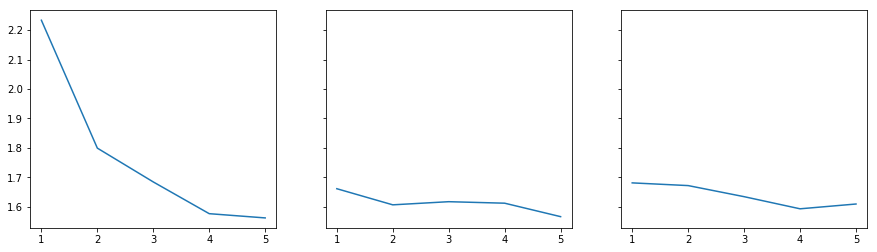

In [42]:
# plot loss history for each value of hyperparameter
f, axes = plt.subplots(1, 3, sharey=True)
f.set_figwidth(15)

plt.setp(axes, xticks=np.arange(0, len(plot_data[0.01]), 1)+1)

for i, lr in enumerate(plot_data.keys()):
    axes[i].plot(np.arange(len(plot_data[lr]))+1, plot_data[lr])

### We will go with learning rate 0.1 as it provides a steep fall in loss than the other LRs tried.

In [12]:
lr = 0.1

In [13]:

#****************************************

import keras

callbacks_list = []


## Note -
## I chose the method of decaying learning Rate after each epoch as it gave 
## better performance than ReduceLROnPlateau method

class DecayLR(keras.callbacks.Callback):
    def __init__(self, base_lr=0.001, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    # set lr on_train_begin
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    # change learning rate at the end of epoch
    def on_epoch_end(self, epoch, logs={}):
        #new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        #new_lr = self.base_lr * (0.75 ** (epoch // self.decay_epoch))
        new_lr = self.base_lr * (0.90 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)
        print("New LR = ", new_lr, "\n")
        
LR = DecayLR(base_lr=lr)


## Use EarlyStop to stop Learning if val_categotical_accuracy is not improving for 5 consecutive epochs
ES = EarlyStopping(monitor='val_categorical_accuracy', patience=5, verbose=1, mode='auto')


curr_dt_time = datetime.datetime.now()

def create_checkpoint():
    
    curr_dt_time = datetime.datetime.now()
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
     
    if not os.path.exists(model_name):
        os.mkdir(model_name)
        
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    # Check point best model based on val_categorical_accuracy instead of every epoch's model ( to save disk space )
    checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False)
    return checkpoint



def create_callbacks():
    
    checkpoint = create_checkpoint()
  
    callbacks_list = [checkpoint, ES, LR]
    return callbacks_list
    


##### Now we will try adjusting the batch size to a higher value and test how it goes.

### Tried few experiments and arrived at optimum batch size 60,  as any higher value threw error in GPU

#### We will check if batch size 60 is fine with a small number of data and epochs

In [15]:
num_train = 150
num_val = 30

batch_size = 60  
num_epochs = 3
lr = 0.1


In [47]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("Training steps per epoch : ", steps_per_epoch)
print("Validation steps per epoch :", validation_steps)

Training steps per epoch :  3
Validation steps per epoch : 1


In [48]:
print_param_details()
sgd = optimizers.SGD(lr=lr, clipnorm=1.)
# model and generators

model = create_conv3d_model_1()
   
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=[LR],
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Number of training Sequences : 150
Number of validation sequences : 30
Batch Size : 60
Number of Epochs : 3


Epoch 1/3


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


3/3 [==============================] - 12s 4s/step - loss: 2.1082 - categorical_accuracy: 0.2333 - val_loss: 1.9039 - val_categorical_accuracy: 0.2000
New LR =  0.1 

Epoch 2/3
3/3 [==============================] - 11s 4s/step - loss: 2.1862 - categorical_accuracy: 0.2000 - val_loss: 1.7164 - val_categorical_accuracy: 0.1667
New LR =  0.09000000000000001 

Epoch 3/3
3/3 [==============================] - 11s 4s/step - loss: 1.6473 - categorical_accuracy: 0.2111 - val_loss: 1.5697 - val_categorical_accuracy: 0.3333
New LR =  0.08100000000000002 



In [49]:
clear_model_mem(model)

## Now try our simple Conv3D with the full data set and a larger number of epochs

In [14]:
#********************************

num_train = 663
num_val = 100

num_epochs = 40
batch_size = 60
lr=0.1

In [15]:
#***********************************************

train_doc2 = train_doc[:num_train]
train_generator = generator(train_path, train_doc2, batch_size)

val_doc2 = val_doc[:num_val]
val_generator = generator(val_path, val_doc2, batch_size)

num_train_sequences = len(train_doc2)
num_val_sequences = len(val_doc2)

print(num_train_sequences)
print(num_val_sequences)

663
100


In [16]:
#********************************************

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("Training steps per epoch : ", steps_per_epoch)
print("Validation steps per epoch :", validation_steps)

Training steps per epoch :  12
Validation steps per epoch : 2


In [19]:
sgd = optimizers.SGD(lr=lr, clipnorm=1.)

# model and generators

model = create_conv3d_model_1()
   
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 13, 118, 118, 32)  2624      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 59, 59, 32)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 59, 59, 32)     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 668352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               85549184  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total para

In [20]:
print_param_details()

callbacks_list = create_callbacks()

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Number of training Sequences : 663
Number of validation sequences : 100
Batch Size : 60
Number of Epochs : 40


Epoch 1/40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


12/12 [==============================] - 198s 16s/step - loss: 1.8909 - categorical_accuracy: 0.1720 - val_loss: 1.5643 - val_categorical_accuracy: 0.3000

Epoch 00001: val_categorical_accuracy improved from -inf to 0.30000, saving model to model_init_2020-09-1207_09_49.790618/model-00001-1.91368-0.18552-1.56425-0.30000.h5
New LR =  0.1 

Epoch 2/40
12/12 [==============================] - 75s 6s/step - loss: 1.5499 - categorical_accuracy: 0.2489 - val_loss: 1.4790 - val_categorical_accuracy: 0.4300

Epoch 00002: val_categorical_accuracy improved from 0.30000 to 0.43000, saving model to model_init_2020-09-1207_09_49.790618/model-00002-1.53375-0.26848-1.47898-0.43000.h5
New LR =  0.09000000000000001 

Epoch 3/40
12/12 [==============================] - 64s 5s/step - loss: 1.4370 - categorical_accuracy: 0.3453 - val_loss: 1.4371 - val_categorical_accuracy: 0.3400

Epoch 00003: val_categorical_accuracy did not improve from 0.43000
New LR =  0.08100000000000002 

Epoch 4/40
12/12 [========

####  70% is the best validation accuracy achieved with this model


#### We see that our simple conv3d model is decently working and learning.

In [21]:
clear_model_mem(model)




## 1.2 Conv3d model with one more additional conv layer with 64 feature map filters

## conv3d_model_2

####  conv3d_model_1 + extra Conv3d layer with 64 feature maps (filters)
#### Architecture = Conv3D (32)  --> Conv3D (64) --> MaxPooling3D --> Dropout --> Flatten --> Dense --> Dropout --> Softmax

In [22]:
num_train = 663
num_val = 100
num_epochs = 20
batch_size = 60
lr=0.1

In [23]:
sgd = optimizers.SGD(lr=lr, clipnorm=1.)
# model and generators

model = create_conv3d_model_2()
   
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 13, 118, 118, 32)  2624      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 11, 116, 116, 64)  55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 58, 58, 64)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 58, 58, 64)     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1076480)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               137789568 
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [24]:
print_param_details()

callbacks_list = create_callbacks()

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Number of training Sequences : 663
Number of validation sequences : 100
Batch Size : 60
Number of Epochs : 20


Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


ResourceExhaustedError: OOM when allocating tensor with shape[60,11,116,116,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/SGD/gradients/max_pooling3d_1/MaxPool3D_grad/MaxPool3DGrad = MaxPool3DGrad[T=DT_FLOAT, TInput=DT_FLOAT, data_format="NDHWC", ksize=[1, 2, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 2, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv3d_2/Relu, max_pooling3d_1/MaxPool3D, training/SGD/gradients/AddN_2)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


### We see that conv3d model with extra layer with 64 filters causes memory exhaustion issue.




In [30]:
clear_model_mem(model)

## 1.3 Conv3d model with extra conv layer with just 32 feature maps

## conv3d_model_3

#### conv3d_model_1 + extra Conv3d layer, but with 32 feature maps (filters) instead of 64.   With only one MaxPooling3D layer
#### Architecture = Conv3D (32)  --> Conv3D (32) --> MaxPooling3D --> Dropout --> Flatten --> Dense --> Dropout --> Softmax


In [17]:
# ******************************

num_train = 663
num_val = 100
num_epochs = 40
batch_size = 60
lr=0.1


In [33]:
sgd = optimizers.SGD(lr=lr, clipnorm=1.)

model = create_conv3d_model_3()

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 13, 118, 118, 32)  2624      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 11, 116, 116, 32)  27680     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 58, 58, 32)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 58, 58, 32)     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 538240)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               68894848  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [34]:
print_param_details()

callbacks_list = create_callbacks()

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



Number of training Sequences : 663
Number of validation sequences : 100
Batch Size : 60
Number of Epochs : 40


Epoch 1/40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


12/12 [==============================] - 83s 7s/step - loss: 1.6327 - categorical_accuracy: 0.2181 - val_loss: 1.5685 - val_categorical_accuracy: 0.3100

Epoch 00001: val_categorical_accuracy improved from -inf to 0.31000, saving model to model_init_2020-09-1207_42_08.159678/model-00001-1.62470-0.23529-1.56846-0.31000.h5
New LR =  0.1 

Epoch 2/40
12/12 [==============================] - 64s 5s/step - loss: 1.5663 - categorical_accuracy: 0.2572 - val_loss: 1.5008 - val_categorical_accuracy: 0.2100

Epoch 00002: val_categorical_accuracy did not improve from 0.31000
New LR =  0.09000000000000001 

Epoch 3/40
12/12 [==============================] - 61s 5s/step - loss: 1.4280 - categorical_accuracy: 0.3677 - val_loss: 1.4064 - val_categorical_accuracy: 0.4800

Epoch 00003: val_categorical_accuracy improved from 0.31000 to 0.48000, saving model to model_init_2020-09-1207_42_08.159678/model-00003-1.41203-0.39668-1.40641-0.48000.h5
New LR =  0.08100000000000002 

Epoch 4/40
12/12 [==========

In [35]:
clear_model_mem(model)

#### We achieved 68% val_categorical_accuracy with this CNN architecture.

## 1.4  conv3d_model_4 

### conv3d_model_3 + additional MaxPooling and dropout between the two Conv3D layers

#### Architecture= Conv3D(32)  --> MaxPooling3D --> Dropout --> Conv3D(32) --> MaxPooling3D --> Dropout --> Flatten --> Dense --> Dropout -- -->Softmax



In [36]:
sgd = optimizers.SGD(lr=lr, clipnorm=1.)
# model and generators

model = create_conv3d_model_4()

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 13, 118, 118, 32)  2624      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 59, 59, 32)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 59, 59, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 4, 57, 57, 32)     27680     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 2, 28, 28, 32)     0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 28, 28, 32)     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
__________

In [37]:
print_param_details()

callbacks_list = create_callbacks()

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Number of training Sequences : 663
Number of validation sequences : 100
Batch Size : 60
Number of Epochs : 40


Epoch 1/40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


12/12 [==============================] - 74s 6s/step - loss: 1.6544 - categorical_accuracy: 0.1873 - val_loss: 1.5973 - val_categorical_accuracy: 0.2200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.22000, saving model to model_init_2020-09-1208_01_36.232603/model-00001-1.63452-0.20211-1.59727-0.22000.h5
New LR =  0.1 

Epoch 2/40
12/12 [==============================] - 63s 5s/step - loss: 1.5936 - categorical_accuracy: 0.2271 - val_loss: 1.5157 - val_categorical_accuracy: 0.2600

Epoch 00002: val_categorical_accuracy improved from 0.22000 to 0.26000, saving model to model_init_2020-09-1208_01_36.232603/model-00002-1.59604-0.21870-1.51572-0.26000.h5
New LR =  0.09000000000000001 

Epoch 3/40
12/12 [==============================] - 60s 5s/step - loss: 1.5251 - categorical_accuracy: 0.3054 - val_loss: 1.4639 - val_categorical_accuracy: 0.3200

Epoch 00003: val_categorical_accuracy improved from 0.26000 to 0.32000, saving model to model_init_2020-09-1208_01_36.232603/mo

#### We do not see good results with this architecture

In [38]:
clear_model_mem(model)

## 1.5 conv3d_model_5
## conv3d_model_4 + BatchNormalization 
#### Architecture = Conv3D(32)  --> BatchNormalization --> MaxPooling3D --> Dropout --> Conv3D (32) --> BatchNormalization --> MaxPooling3D --
####            ----> Dropout --> Flatten --> Dense --> Dropout --> Softmax

In [18]:
sgd = optimizers.SGD(lr=lr, clipnorm=1.)
# model and generators

model = create_conv3d_model_5()

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 13, 118, 118, 32)  2624      
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 118, 118, 32)  128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 59, 59, 32)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 59, 59, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 4, 57, 57, 32)     27680     
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 57, 57, 32)     128       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 2, 28, 28, 32)     0         
__________

In [19]:
print_param_details()

callbacks_list = create_callbacks()
#print(callbacks_list)
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Number of training Sequences : 663
Number of validation sequences : 100
Batch Size : 60
Number of Epochs : 40


Epoch 1/40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


12/12 [==============================] - 207s 17s/step - loss: 2.5310 - categorical_accuracy: 0.2998 - val_loss: 1.2098 - val_categorical_accuracy: 0.5100

Epoch 00001: val_categorical_accuracy improved from -inf to 0.51000, saving model to model_init_2020-09-1208_33_21.951032/model-00001-2.57024-0.29713-1.20983-0.51000.h5
New LR =  0.1 

Epoch 2/40
12/12 [==============================] - 70s 6s/step - loss: 1.6138 - categorical_accuracy: 0.3076 - val_loss: 1.2257 - val_categorical_accuracy: 0.4900

Epoch 00002: val_categorical_accuracy did not improve from 0.51000
New LR =  0.09000000000000001 

Epoch 3/40
12/12 [==============================] - 56s 5s/step - loss: 1.3884 - categorical_accuracy: 0.3873 - val_loss: 1.1561 - val_categorical_accuracy: 0.5800

Epoch 00003: val_categorical_accuracy improved from 0.51000 to 0.58000, saving model to model_init_2020-09-1208_33_21.951032/model-00003-1.38421-0.41780-1.15612-0.58000.h5
New LR =  0.08100000000000002 

Epoch 4/40
12/12 [========

### We have achieved the val_categorical_accuracy of 80% , the best so far 

In [20]:
clear_model_mem(model)

# 2. CONV2D + LSTM Models Experiments

## 2.1 LSTM based Model
## cnn_lstm_model_1
#### Architecture = Conv2D --> MaxPooling2D --> Flatten --> LSTM --> Dense --> Dropout --> Softmax

In [18]:
num_train = 663
num_val = 100

num_epochs = 40
batch_size = 60
lr=0.1

In [22]:
sgd = optimizers.SGD(lr=lr, clipnorm=1.)


model = create_cnn_lstm_model_1()

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 118, 118, 32)  896       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 59, 59, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 111392)        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               57098752  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total para

In [23]:
print_param_details()

callbacks_list = create_callbacks()
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



Number of training Sequences : 663
Number of validation sequences : 100
Batch Size : 60
Number of Epochs : 40


Epoch 1/40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


12/12 [==============================] - 79s 7s/step - loss: 1.6820 - categorical_accuracy: 0.2355 - val_loss: 1.9114 - val_categorical_accuracy: 0.2500

Epoch 00001: val_categorical_accuracy improved from -inf to 0.25000, saving model to model_init_2020-09-1209_03_02.477440/model-00001-1.67274-0.22775-1.91142-0.25000.h5
New LR =  0.1 

Epoch 2/40
12/12 [==============================] - 55s 5s/step - loss: 1.6650 - categorical_accuracy: 0.2355 - val_loss: 1.5612 - val_categorical_accuracy: 0.2900

Epoch 00002: val_categorical_accuracy improved from 0.25000 to 0.29000, saving model to model_init_2020-09-1209_03_02.477440/model-00002-1.67585-0.22775-1.56123-0.29000.h5
New LR =  0.09000000000000001 

Epoch 3/40
12/12 [==============================] - 65s 5s/step - loss: 1.5981 - categorical_accuracy: 0.2363 - val_loss: 1.5634 - val_categorical_accuracy: 0.3700

Epoch 00003: val_categorical_accuracy improved from 0.29000 to 0.37000, saving model to model_init_2020-09-1209_03_02.477440/mo

#### The maximum we reached is 56% validation accuracy with LSTM model       

In [24]:
clear_model_mem(model)

## 2.2 GRU Model 1


## cnn_gru_model_1 
#### Architecture = Conv2D --> MaxPooling2D --> Dropout --> Flatten --> GRU --> Dense --> Dropout --> Softmax

In [19]:
num_train = 663
num_val = 100

num_epochs = 40
batch_size = 60
lr=0.1

In [26]:
sgd = optimizers.SGD(lr=lr, clipnorm=1.)
# model and generators

model = create_cnn_gru_model_1()

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 118, 118, 32)  896       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 59, 59, 32)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 59, 59, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 111392)        0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               42824064  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [27]:
print_param_details()

callbacks_list = create_callbacks()
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Number of training Sequences : 663
Number of validation sequences : 100
Batch Size : 60
Number of Epochs : 40


Epoch 1/40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


12/12 [==============================] - 81s 7s/step - loss: 1.6841 - categorical_accuracy: 0.2145 - val_loss: 1.6186 - val_categorical_accuracy: 0.1700

Epoch 00001: val_categorical_accuracy improved from -inf to 0.17000, saving model to model_init_2020-09-1209_22_24.482476/model-00001-1.67516-0.20513-1.61860-0.17000.h5
New LR =  0.1 

Epoch 2/40
12/12 [==============================] - 56s 5s/step - loss: 1.6325 - categorical_accuracy: 0.1804 - val_loss: 1.6006 - val_categorical_accuracy: 0.2400

Epoch 00002: val_categorical_accuracy improved from 0.17000 to 0.24000, saving model to model_init_2020-09-1209_22_24.482476/model-00002-1.62535-0.19457-1.60064-0.24000.h5
New LR =  0.09000000000000001 

Epoch 3/40
12/12 [==============================] - 57s 5s/step - loss: 1.6079 - categorical_accuracy: 0.2209 - val_loss: 1.5858 - val_categorical_accuracy: 0.2200

Epoch 00003: val_categorical_accuracy did not improve from 0.24000
New LR =  0.08100000000000002 

Epoch 4/40
12/12 [==========

#### Validation accuracy with this model is just 44% which does not seem good

In [28]:
clear_model_mem(model)

## 2.3 GRU Model -2

## cnn_gru_model_2
#### cnn_gru_model_1 + BatchNormalization
#### Architecture = Conv2D --> BatchNormalization --> MaxPooling2D --> BatchNormalization --> Dropout --> Flatten --> GRU -->
####                       --> Dense --> Dropout --> Softmax

In [20]:
num_train = 663
num_val = 100

num_epochs = 40
batch_size = 60
lr=0.1

In [21]:
sgd = optimizers.SGD(lr=lr, clipnorm=1.)
# model and generators

model = create_cnn_gru_model_2()

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 118, 118, 32)  896       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 118, 118, 32)  128       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 59, 59, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 59, 59, 32)    128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 59, 59, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 111392)        0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               42824064  
__________

In [22]:
print_param_details()

callbacks_list = create_callbacks()
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Number of training Sequences : 663
Number of validation sequences : 100
Batch Size : 60
Number of Epochs : 40


Epoch 1/40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


12/12 [==============================] - 196s 16s/step - loss: 1.8015 - categorical_accuracy: 0.2844 - val_loss: 1.3434 - val_categorical_accuracy: 0.4700

Epoch 00001: val_categorical_accuracy improved from -inf to 0.47000, saving model to model_init_2020-09-1212_11_42.787283/model-00001-1.84336-0.28054-1.34338-0.47000.h5
New LR =  0.1 

Epoch 2/40
12/12 [==============================] - 90s 8s/step - loss: 1.2709 - categorical_accuracy: 0.4712 - val_loss: 1.1254 - val_categorical_accuracy: 0.5700

Epoch 00002: val_categorical_accuracy improved from 0.47000 to 0.57000, saving model to model_init_2020-09-1212_11_42.787283/model-00002-1.23977-0.50830-1.12535-0.57000.h5
New LR =  0.09000000000000001 

Epoch 3/40
12/12 [==============================] - 64s 5s/step - loss: 0.9532 - categorical_accuracy: 0.6079 - val_loss: 1.1091 - val_categorical_accuracy: 0.5100

Epoch 00003: val_categorical_accuracy did not improve from 0.57000
New LR =  0.08100000000000002 

Epoch 4/40
12/12 [========

#### This GRU model gave best validation accuracy as 73% 

In [23]:
clear_model_mem(model)

# Conclusion :




### We experimented with various types of Conv3D and CNN+RNN model architectures. 
### The best model out of these experiments is conv3d_model_5 with validation accuracy of 80%,  followed by 
### cnn_gru_model_2 with validation accuracy as 73%